# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

ImportError: No module named cifar

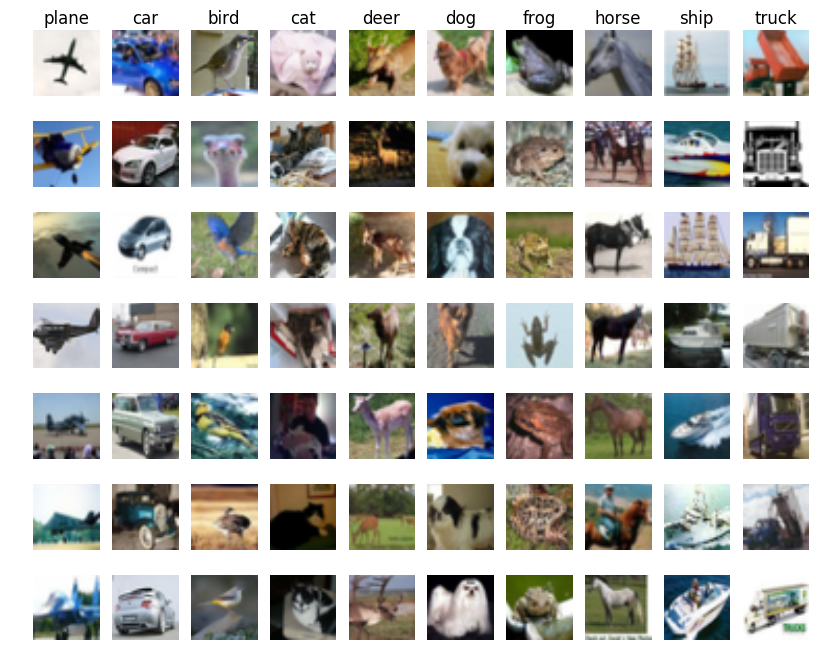

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5105)
/home/ubuntu/anaconda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Так задаётся архитектура нейронки

In [5]:
X_train1 = [x for x in X_train]
for i in range(len(X_train)):
    X_train1[i] = X_train[i].transpose()
    X_train1[i] = [t.transpose() for t in X_train1[i]]
    X_train1[i] = np.array(X_train1[i])
X_train1 = np.array(X_train1)
print X_train1.shape
print X_train[0][5][8][2], X_train1[0][2][5][8]

(50000, 3, 32, 32)
33.0 33.0


In [6]:
X_train2 = np.array([[x[0]] for x in X_train1])
print X_train2.shape

(50000, 1, 32, 32)


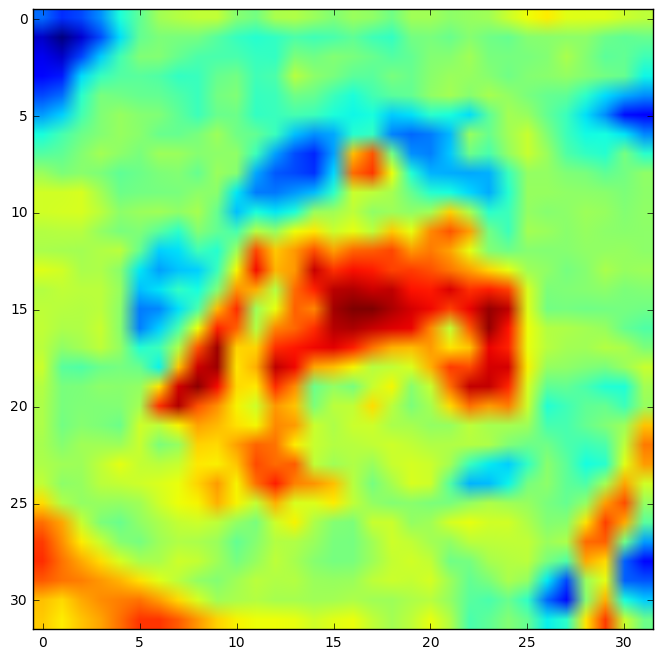

In [90]:
plt.imshow(X_train2[0][0])

In [33]:
input_layer = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
conv1 = lasagne.layers.Conv2DLayer(input_layer, num_filters = 16, filter_size = (10, 10))
pool1 = lasagne.layers.MaxPool2DLayer(conv1, pool_size = (2, 2))
#conv2 = lasagne.layers.Conv2DLayer(pool1, num_filters = 10, filter_size = (5, 5))
#pool2 = lasagne.layers.MaxPool2DLayer(conv2, pool_size = (2, 2))
# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense1 = lasagne.layers.DenseLayer(pool1, num_units = 50, nonlinearity = sigmoid)
#dropout1 = lasagne.layers.DropoutLayer(dense1, p = 0.3)
dense_output = lasagne.layers.DenseLayer(dense1, num_units = 10, nonlinearity=softmax)

In [34]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [35]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [36]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

In [37]:
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.001)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd, allow_input_downcast = True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast = True)

### Вот и всё, пошли её учить

In [27]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [28]:
print X_train1.shape, input_layer.shape

(50000, 3, 32, 32) (None, 3, 32, 32)


In [14]:
X_test1 = [x for x in X_test]
for i in range(len(X_test1)):
    X_test1[i] = X_test[i].transpose()
    X_test1[i] = [t.transpose() for t in X_test1[i]]
    X_test1[i] = np.array(X_test1[i])
X_test1 = np.array(X_test1)
print X_test1.shape
print X_test[0][7][15][2], X_test1[0][2][7][15]

(10000, 3, 32, 32)
79.0 79.0


In [15]:
X_test2 = np.array([[x[0]] for x in X_test1])
print X_test2.shape

(10000, 1, 32, 32)


In [ ]:
train(1000, 100, 10)

In [31]:
import time

def train(num_epochs, batch_size, verbose = 10):
    for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train1, y_train,batch_size):
            inputs, targets = batch
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_test1, y_test, batch_size):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1


        if epoch % verbose == verbose - 1:
            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))

            print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
            print("  train accuracy:\t\t{:.2f} %".format(
                train_acc / train_batches * 100))
            print("  validation accuracy:\t\t{:.2f} %".format(
                val_acc / val_batches * 100))
        train_accs.append(train_acc / train_batches * 100)
        val_accs.append(val_acc / val_batches * 100)
train_accs = []
val_accs = []

In [30]:
import time

num_epochs = 1000 #количество проходов по данным

batch_size = 100 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train1, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test1, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    if epoch % 10 == 9:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3